In [33]:
import os
import pickle
import numpy as np
from tqdm import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add

In [34]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [35]:
#EXTRACT IMAGE FEATURES

In [36]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)
#summarize 
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#extract features from image
features={}
directory=os.path.join(BASE_DIR,'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path=directory+'/'+img_name
    image=load_img(img_path,target_size=(224,224))

    image=img_to_array(image)
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature


  0%|          | 0/8091 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1756930024.845199     102 service.cc:148] XLA service 0x7a49cc004f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756930024.846143     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756930024.846163     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756930024.980136     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756930027.543521     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
  1%|          | 98/8091 [00:11<16:08,  8.26it/s] 


KeyboardInterrupt: 

In [9]:
#store features in pickle
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))


In [37]:
#load features from pickle
with open(os.path.join('/kaggle/input/feature/features.pkl'),'rb') as f:
    features=pickle.load(f)

In [38]:
#Load the captions Data

In [39]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    caption_doc=f.read()

In [40]:
#create mapping of image to captions
mapping={}

for line in tqdm(caption_doc.split('\n')):
    #split the line by comma
    tokens=line.split(',')
    if len(line)<2:
        continue
    image_id,caption=tokens[0],tokens[1:]
    #remove extension from imageID
    image_id=image_id.split('.')[0]
    #convert caption list into string
    caption="".join(caption)

    if image_id not in mapping:
        mapping[image_id]=[]

    mapping[image_id].append(caption)
    

100%|██████████| 40456/40456 [00:00<00:00, 810957.57it/s]


In [41]:
len(mapping)

8091

In [42]:
#Preprocess text data

In [43]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption=captions[i]
            caption=caption.lower()
            caption=caption.replace('[^A-Za-z]','')
            caption=caption.replace('\s+',' ')
            caption='startseq '+" ".join([word for word in caption.split() if len(word)>1])+' endseq'
            captions[i]=caption
            
            

In [44]:
#before preprocess of text
mapping['1000268201_693b08cb0e']


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [45]:
#preprocess the text
clean(mapping)

In [46]:
#after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [47]:
all_captions=[]

for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [48]:
len(all_captions)

40455

In [49]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [50]:
with open(os.path.join(WORKING_DIR, 'all_captions.pkl'), 'wb') as f:
    pickle.dump(all_captions, f)


In [20]:
#tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [21]:
vocab_size

8485

In [22]:
#get maximum length of caption available
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

In [21]:
#TRAIN TEST SPLIT

In [22]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]

In [23]:
#create data generator to get data in batch
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [24]:
#Model Creation

In [4]:
from keras.layers import add 

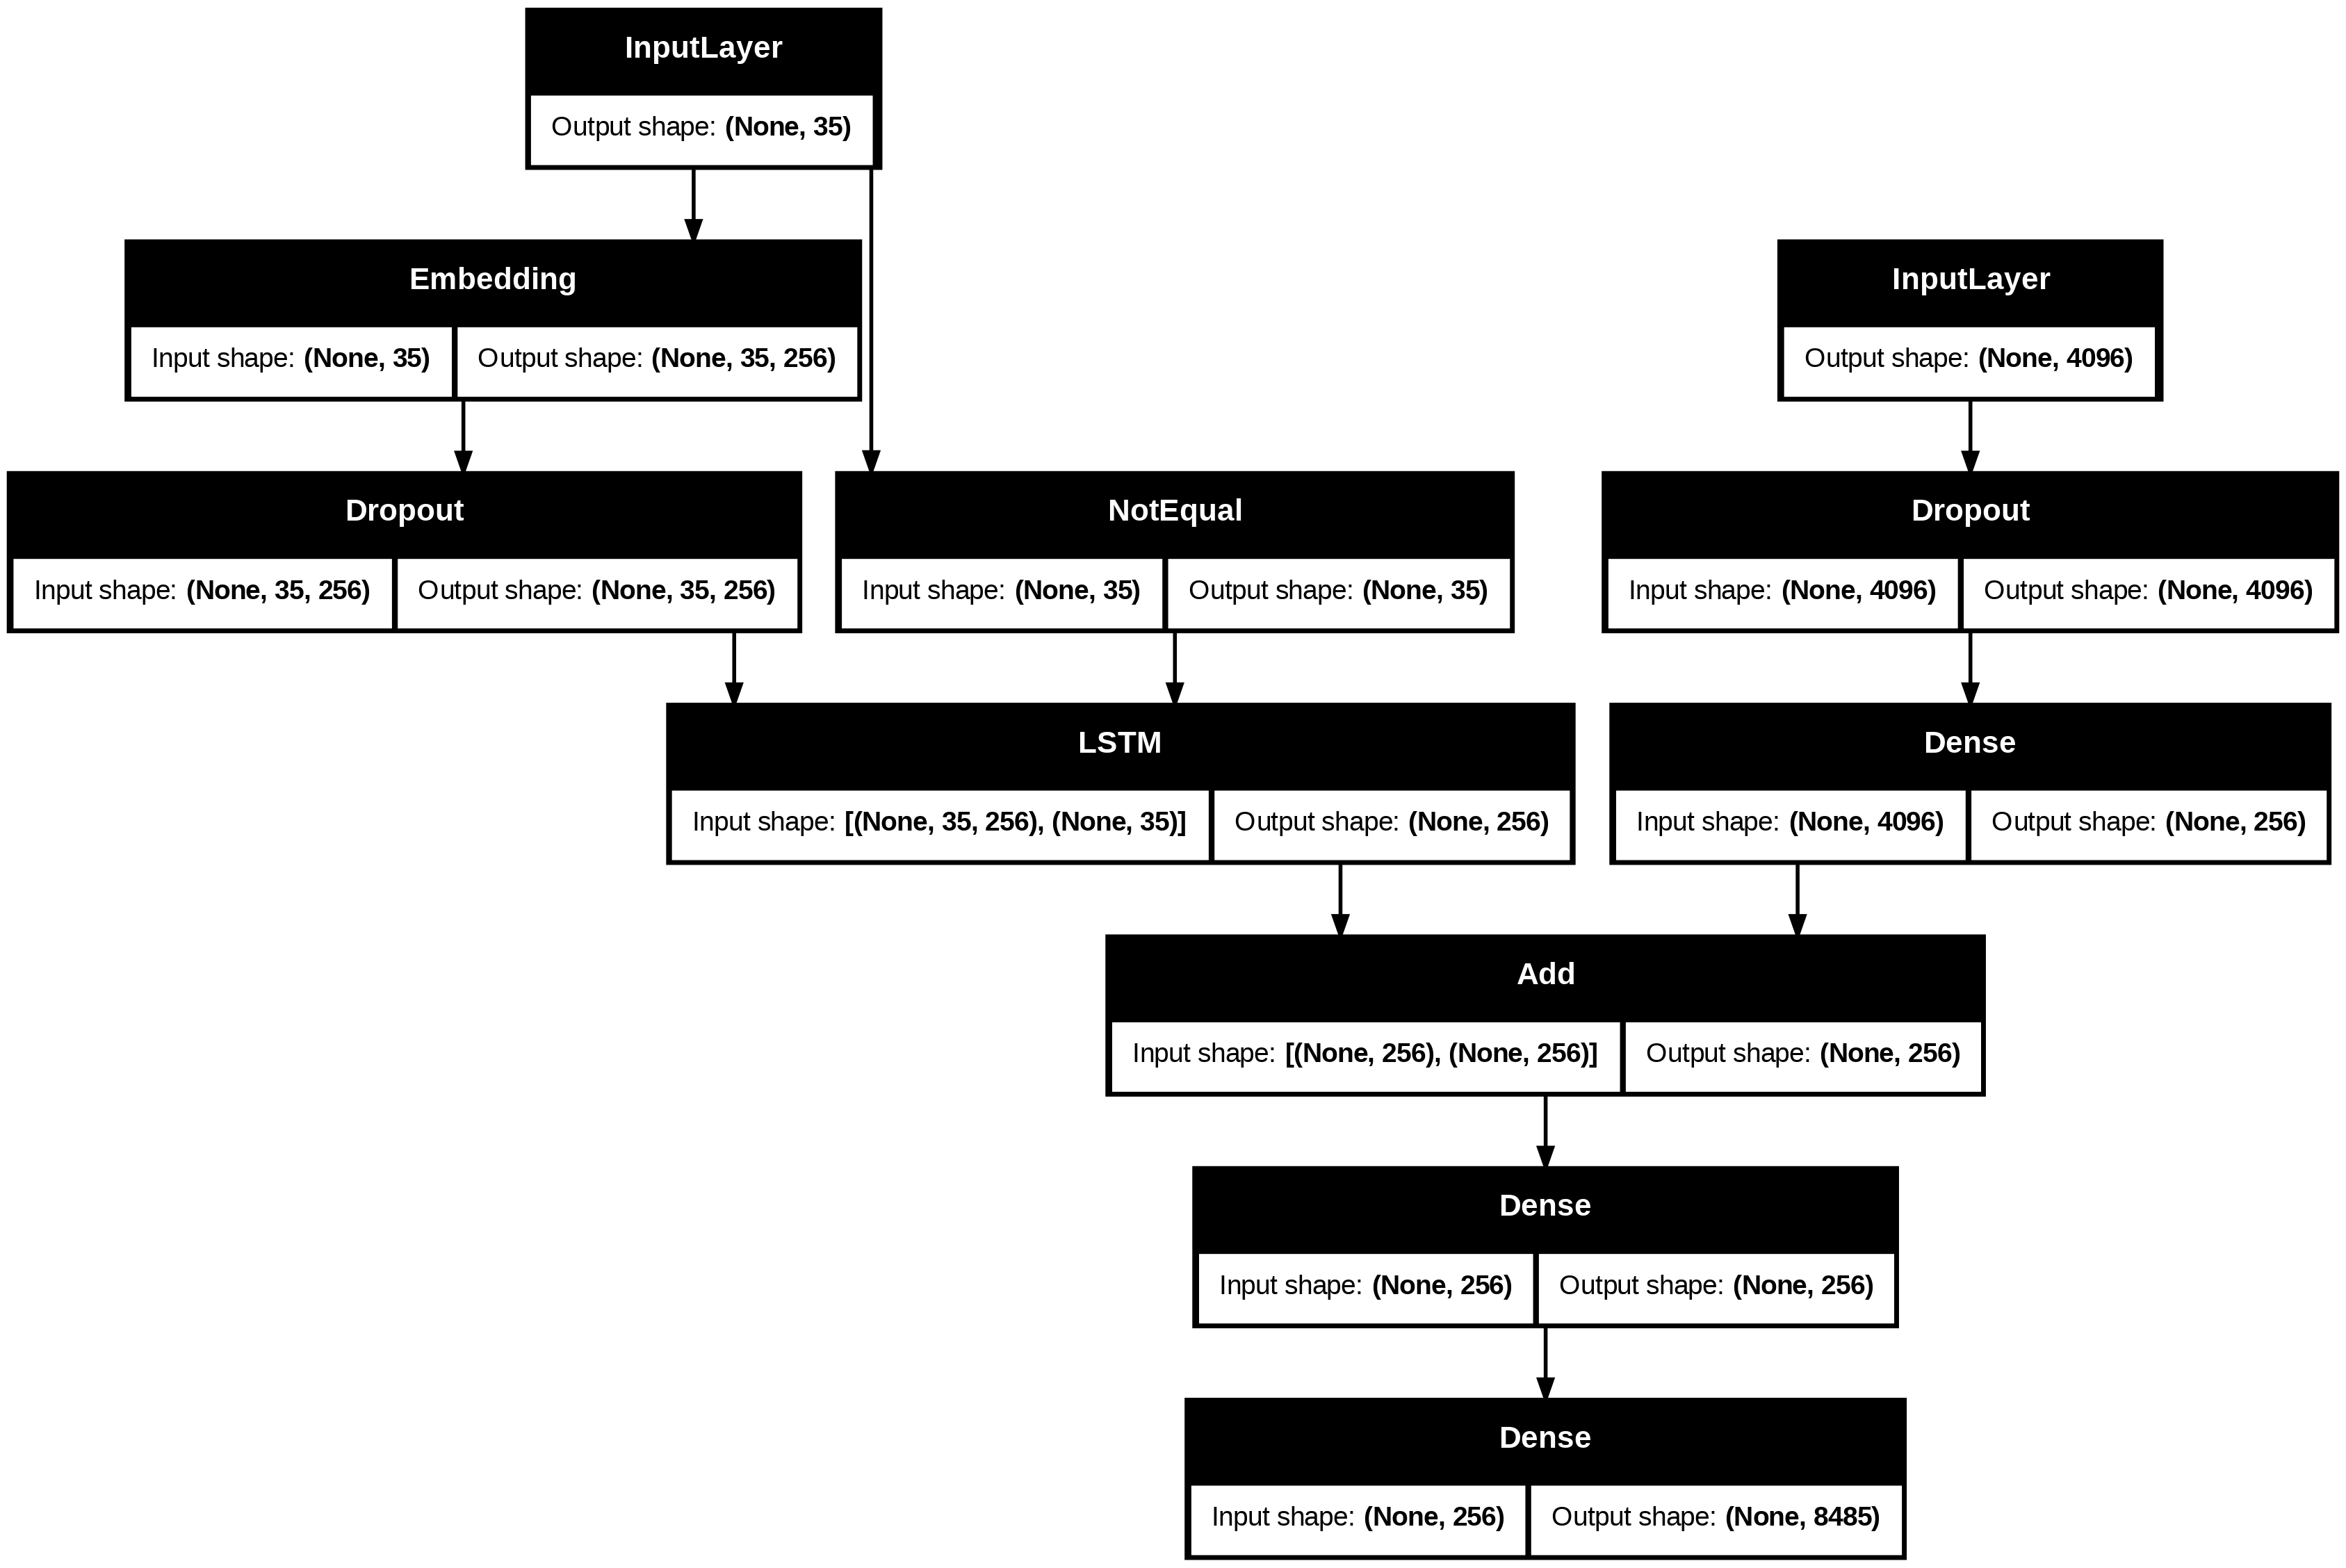

In [26]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [27]:
# train the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

I0000 00:00:1757783078.520426      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 232ms/step - loss: 5.7779
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 4.0356
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 227ms/step - loss: 3.5752
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 3.2959
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 3.0884
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.9312
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - loss: 2.8114
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.7111
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.6271
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 2.5503
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 2.4841
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.4299
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.3838
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 227ms/step - loss: 2.3385
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 2.2998
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 226ms/step - loss: 2.2640
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 227ms/step - loss: 2.23

In [28]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [26]:
#Generate Captions for the Image
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [31]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [10:06<00:00,  1.34it/s]


BLEU-1: 0.527486
BLEU-2: 0.303864


In [28]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown and white dog is running through the snow endseq
startseq dog is running in the snow endseq
startseq dog running through snow endseq
startseq white and brown dog is running through snow covered field endseq
startseq the white and brown dog is running over the surface of the snow endseq


I0000 00:00:1757794199.160653      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


--------------------Predicted--------------------
startseq dog running through snow endseq


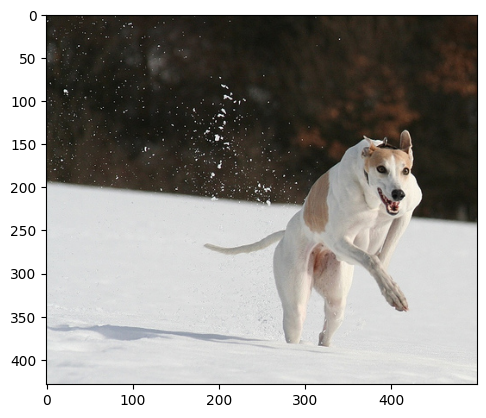

In [29]:
generate_caption("101654506_8eb26cfb60.jpg")

---------------------Actual---------------------
startseq black dog carries green toy in his mouth as he walks through the grass endseq
startseq black dog carrying something through the grass endseq
startseq black dog has blue toy in its mouth endseq
startseq dog in grass with blue item in his mouth endseq
startseq wet black dog is carrying green toy through the grass endseq
--------------------Predicted--------------------
startseq black dog is running through field of grass and grass scene endseq


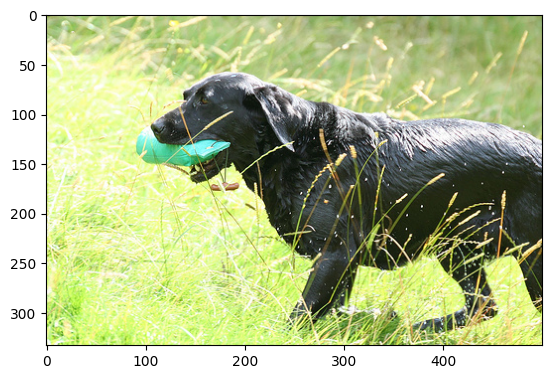

In [30]:
generate_caption("1026685415_0431cbf574.jpg")

---------------------Actual---------------------
startseq boy with toy gun endseq
startseq little boy in orange shorts playing with toy endseq
startseq young boy with his foot outstretched aims toy at the camera in front of fireplace endseq
startseq young child plays with his new light-up toy endseq
startseq boy with toy gun pointed at the camera endseq
--------------------Predicted--------------------
startseq boy plays with toy toy in the house endseq


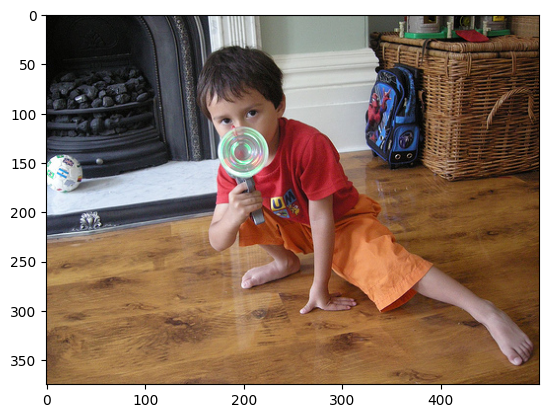

In [31]:
generate_caption("1096395242_fc69f0ae5a.jpg")